# Marginal densities


* Distributions: $f(\sigma,t)$ and $g(p,t)$
* $\partial_t f  =  -G\dot\gamma~\partial_{\sigma}f    +     
                           D(t)~\partial^2_{\sigma} f  - 
                           \tau^{-1}~\mathcal{H}(f_y)~f +
                           \Gamma(t)~\delta(\sigma)$
* $\partial_t g  =    D(t)~\partial^2_{p} g  +
                           \tau^{-1}~\partial_p (p.g)$
<br> with 
$\Gamma(t)=\tau^{-1}\int\mathcal{H}(f_y)~f(\sigma,t)~d\sigma$ and $D(t)=\alpha~\Gamma(t) $

## import libraries

In [31]:
import numpy as np
from matplotlib import animation
import matplotlib.pylab as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams["animation.html"] = "html5"

## input parameters

In [168]:
#------------------------
#--- input parameters
#------------------------
ngrid = 101 #--- spatial discretization
D = 1.0 #--- diffusion factor
L = 10 * df_uniax['uniax'].mean() #--- stress domain
ntime = 50000 #30000  #--- time steps
G = 1.0 #--- shear modulus
sigma_c = df_uniax['uniax'].mean() #10.0 #--- stress threshold
alpha = 1.0 #--- 
width = 0.01*sigma_c #--- initial width of p(\sigma)
#assert width >= dx
#
dt  = 0.01 #0.2 #---
gammaDot = 0.00001 #0.1*(D*dt)**0.5 / dt / G  #--- convection rate
tau = 1.0/max(D/dx/dx, gammaDot*G/dx) #--- relaxation time scale
assert dt  <= tau #---
#print 'dt=%s'%dt
#--- integration
dx = L / ngrid #--- 
dx_sq = dx * dx
D_numerical = .2*0.5 * dx_sq / dt #--- numerical diffusion
#
#tau_inv2nd = .5*D/sigma_c ** 2 #--- relaxation rate for pressure






## discretization & integration

* $\partial_t f=\frac{f(t_n+\Delta t,\sigma_n)-f(t_n,\sigma_n)}{\Delta t}$
* $\partial^2_{\sigma} f=\frac{f(t_n,\sigma_{n+1})+f(t_n,\sigma_{n-1})-2f(t_n,\sigma_{n})}{{\Delta\sigma}^2}$
* $\partial_{\sigma} f=\frac{f(t_n,\sigma_{n+1})-f(t_n,\sigma_{n-1})}{2\Delta\sigma}$


In [119]:
def leftShift(x):
    return x[1:]+[x[0]]

def rightShift(x):
    return [x[-1]]+x[:-1]
    
def derivative1st( y ):
    ls = leftShift(y.tolist()[0])
    rs = rightShift(y.tolist()[0])
    return (np.array(ls) - np.array(rs))*0.5


#-----------------------------
#--- discretized quantities
#-----------------------------
sigma = np.linspace(-(ngrid/2)*dx,(ngrid/2)*dx,ngrid) #--- discretized stress
press = np.linspace(-(ngrid/2)*dx,(ngrid/2)*dx,ngrid) #--- discretized pressure

#--- delta function
delta = np.array( np.zeros(ngrid))
delta[ngrid/2]=1.0 / dx

#--- define new variables
tau_inv = 1.0 /tau
pref = dx * dt / tau
GtimesGammaDot = G * gammaDot * dt
assert GtimesGammaDot <= 0.5, 'e=%s'%GtimesGammaDot
De = D*dt/dx_sq
dtDelta = dt * delta
dtdx_sq = dt / dx_sq

#-----------------------------
#--- initial profile
#-----------------------------
#--- shear
P=np.matrix(np.zeros(ntime*ngrid).reshape(ntime,ngrid))
P[0]=np.exp(- 0.5*(sigma/width)**2)
P[0] /= np.sum(P[0])
#--- pressure
P_press=np.matrix(np.zeros(ntime*ngrid).reshape(ntime,ngrid))
P_press[0]=np.exp(- 0.5*(sigma/width)**2)
P_press[0] /= np.sum(P_press[0])

#-----------------------------
#--- numerical integration
#-----------------------------
d={}
vdt = {}
gg={}
var={}
sigma_mean = {}
for itime in xrange(ntime - 1 ):
#    print itime
    Ratio_active = np.sum( P[ itime , sigma >= sigma_c ] )
    Gamma = tau_inv * Ratio_active * dx
    D = alpha * Gamma
    tau_inv2nd = D/sigma_c ** 2
    assert D*dt/dx_sq <= 0.5, 'D*dt/dx_sq=%s'%(D*dt/dx_sq)
    assert abs(1.0-np.sum(P[itime]))<1e-3, 'sum=%s'%(np.sum(P[itime]))
    assert abs(1.0-np.sum(P_press[itime]))<1e-3, 'sum=%s'%(np.sum(P_press[itime]))
    gg[itime]=D
    
    #--- derivatives
    p_deriv_1st = derivative1st( P[ itime ] )
    p_press_deriv_1st = derivative1st( P_press[ itime ] )
    #
    p_deriv_2nd = np.diff(P[ itime ],n=2,append=P[ itime,0],prepend=P[ itime, -1]) #--- 2nd derivative
    p_press_deriv_2nd = np.diff(P_press[ itime ],n=2,append=P_press[ itime,0],prepend=P_press[ itime, -1]) #--- 2nd derivative
    #
    
    #--- update shear stress distribution
    P[ itime + 1 ] = P[ itime ] - GtimesGammaDot * p_deriv_1st  \
                                + ( D + D_numerical ) * dtdx_sq * p_deriv_2nd \
                                -  pref * np.array(P[ itime].tolist()[0]) * (sigma >= sigma_c) \
                                + dtDelta * Gamma 
    #--- update pressure distribution
    P_press[ itime + 1 ] = P_press[ itime ]\
                            + ( D  ) * dtdx_sq * p_press_deriv_2nd\
                            + dt * tau_inv2nd * (P_press[ itime ]+sigma*p_press_deriv_1st / dx) #--- theta * d(x*p)/dx

    #--- pressure variance
    var[itime] = np.sum(sigma**2 * np.array(P_press[ itime ]))/np.sum(np.array(P_press[ itime ]))
    
    #--- mean sigma
    sigma_mean[itime] = np.sum(sigma * np.array(P[ itime ]))


AssertionError: D*dt/dx_sq=1.4500788880670172

## visualization

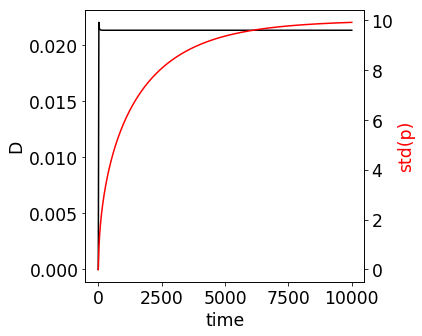

In [170]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
#plt.yscale('log')
#plt.ylim(1e-2,1)
#plt.xlim(0,3)
ax.set_xlabel('time',fontsize='xx-large')
ax.set_ylabel('D',fontsize='xx-large')
ax.plot(np.array(range(ntime - 1 ))*dt,gg.values(),'-',color='black')
ax.tick_params(labelsize='xx-large')

ax2=ax.twinx()
ax2.plot(np.array(range(ntime - 1 ))*dt,np.sqrt(var.values()),'-',color='red')
ax2.set_ylabel('std(p)',color='red',fontsize='xx-large')
ax2.tick_params(labelsize='xx-large')
plt.show()

### stress vs. time

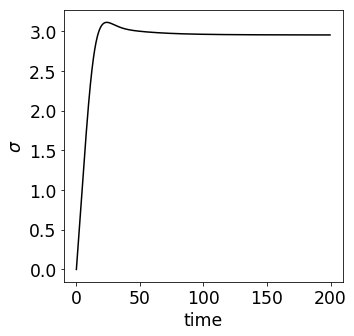

In [143]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
#plt.yscale('log')
#plt.ylim(1e-2,1)
#plt.xlim(0,100)
ax.set_xlabel('time',fontsize='xx-large')
ax.set_ylabel('$\sigma$',fontsize='xx-large')
ax.plot(np.array(range(ntime - 1 ))*dt,sigma_mean.values(),'-',color='black')
ax.tick_params(labelsize='xx-large')

# ax2=ax.twinx()
# ax2.plot(np.array(range(ntime - 1 ))*dt,np.sqrt(var.values()),'-',color='red')
# ax2.set_ylabel('std(p)',color='red',fontsize='xx-large')
# ax2.tick_params(labelsize='xx-large')
plt.show()

### distributions

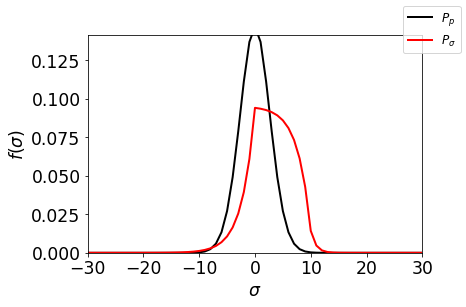

In [144]:
i=itime-1 #--- time
val = P_press


fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-3*sigma_c,3*sigma_c)
ax.set_ylim(0,1.5*P[i,:].max())
ax.set_xlabel('$\sigma$',fontsize='xx-large')
ax.set_ylabel('$f(\sigma)$',fontsize='xx-large')
ax.tick_params(labelsize='xx-large')
#ax.set_yscale('log')
#ax.set_ylim(1e-8,1)

ax.plot(sigma, val[i, :].tolist()[0], color='k', lw=2, label=r'$P_{p}$')[0]
ax.plot(sigma, P[i, :].tolist()[0], color='red', lw=2, label=r'$P_{\sigma}$')[0]
fig.legend(fontsize='large')



### movie

In [145]:
import matplotlib.animation as animation
from IPython.display import HTML

val = P_press

fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-1.5*sigma_c,1.5*sigma_c)
ax.set_ylim(0,2*P[ntime-1,:].max())
ax.set_xlabel('$\sigma$',fontsize='xx-large')
ax.set_ylabel('$f(\sigma)$',fontsize='xx-large')
ax.tick_params(labelsize='xx-large')

ims = []
nframe=100
for itime in xrange(1,ntime,(ntime-1)/nframe):
    line1 = ax.plot(sigma, val[itime, :].tolist()[0], color='k', lw=2, label='t=%s'%i)[0]
    line2 = ax.plot(sigma, P[itime, :].tolist()[0], color='red', lw=2, label='t=%s'%i)[0]
    ims.append([line1,line2])
    
anim = animation.ArtistAnimation(fig, ims, interval=65, blit=True)
plt.close()
# Show the animation
display(HTML(anim.to_html5_video()))

#=========================================
# Save animation as video (if required)
#anim.save('%s/movie.%s.mp4'%(DIR_OUTPT_figs,injection_period))

# Joint Probability
* Distributions: $f(p,\sigma,t)$
* $\partial_t f  =  -G\dot\gamma~\partial_{\sigma}f     +     
                           D(t)~(\partial^2_{\sigma}+\partial^2_{p}) f  - 
                           \tau^{-1}~\mathcal{H}(f_y)~f +
                           \Gamma(t,p)~\delta(\sigma)     +
                           \tau^{-1}~\partial_p (p.f)$
<br> with 
* $\Gamma(t,p)=\tau^{-1}\int\mathcal{H}(f_y)~f(p,\sigma,t)~d\sigma$ 
<br>
* $D(t)=\alpha~\tau^{-1}\int\mathcal{H}(f_y)~f(p,\sigma,t)~d\sigma~dp$

## input parameters

In [215]:
#------------------------
#--- input parameters
#------------------------
ngrid=1001 #--- spatial discretization
D = 1.0 #--- diffusion factor
L = 2 * 10 * df_uniax['uniax'].mean() #--- stress domain
dx = L / ngrid #--- 
ntime = 30000  #--- time steps
G = 1.0 #--- shear modulus
sigma_c = df_uniax['uniax'].mean() #10.0 #--- stress threshold
alpha = 1.0 #--- 
width = 0.01*sigma_c #--- initial width of p(\sigma)
#assert width >= dx
#
dt  = 0.01 #0.2 #---
gammaDot = 0.00001 #0.1*(D*dt)**0.5 / dt / G  #--- convection rate
tau = 0.6 #1.0/max(D/dx/dx, gammaDot*G/dx) #--- relaxation time scale
#assert dt  <= tau #---
#print 'dt=%s'%dt
#--- integration
dy = dx
dx_sq = dx * dx
dy_sq = dy * dy
D_numerical = .2*0.5 * dx_sq / dt #--- numerical diffusion
#
#tau_inv2nd = .5*D/sigma_c ** 2 #--- relaxation rate for pressure

## discretization & integration


In [217]:
def YieldFunc(xv,yv,sigma_c):
#    return yv - xv - sigma_c >= 0.0
    return yv - sigma_c >= 0.0

def GetGamma(f,fy):
    ngrid = f.shape[1]
    gamma_p = np.zeros( ngrid )
    for jcol in xrange( ngrid ):
        gamma_p[jcol] = np.sum( f[:,jcol][fy[:,jcol]] )
    return gamma_p * dy
        
x = np.linspace(-(ngrid/2)*dx,(ngrid/2)*dx,ngrid)
y = np.linspace(-(ngrid/2)*dx,(ngrid/2)*dx,ngrid)
xv, yv = np.meshgrid( x, y )
xv_sq = xv * xv

#-----------------------------
#--- initial profile
#-----------------------------
#--- shear
#f=np.exp(- 0.5*(xv*xv+yv*yv)/width**2)
#f /= np.sum( f ) * dx * dy
f = f0

#--- delta function
delta = np.array(np.zeros(ngrid*ngrid).reshape(ngrid,ngrid))
delta[ngrid/2,:] = 1.0 / dx


#--- yield
fyild = YieldFunc(xv,yv,sigma_c)

gg  = {}
var = {}
sigma_mean = {}

#--- define new variables
tau_inv = 1.0 / tau
GtimesGammaDot = G * gammaDot * dt
De = D*dt/dx_sq
dtDelta = dt * delta
dtdx_sq = dt / dx_sq
dxy = dx * dy
sig2_inv = 1.0 /sigma_c ** 2
dt_div_dxsq = dt/dx_sq
dt_tauinv = dt * tau_inv

for itime in xrange(ntime - 1 ):
    Gamma = tau_inv * np.sum(fyild * f,axis = 0) * dy
    Ratio_active = np.sum( fyild * f ) * dxy
    D = alpha * tau_inv * Ratio_active 
    tau_inv2nd = D * sig2_inv 
    assert D*dt_div_dxsq <= 0.5, 'D*dt/dx_sq=%s'%(D*dt_div_dxsq)
    assert abs(1.0-np.sum(f)*dxy)<1e-3, 'sum=%s'%(np.sum(f)*dxy)
    gg[itime]=D
    
    #--- derivatives
    f_x  = np.diff(f,n=1,append=f[:,0].reshape(ngrid,1),axis=-1) / dx
    f_xx = np.diff(f,n=2,append=f[:,0].reshape(ngrid,1),prepend=f[:,-1].reshape(ngrid,1),axis=-1) / dx_sq
    f_y  = np.diff(f,n=1,append=[f[0]],axis=0) / dy
    f_yy = np.diff(f,n=2,append=[f[0]],prepend=[f[-1]],axis=0) / dy_sq   #--- 2nd derivative
    #
    #--- update shear stress distribution
    delta[ngrid/2,:] = Gamma
    f += - GtimesGammaDot * f_y  \
         + ( D * f_xx + (D + D_numerical) * f_yy ) * dt \
         -  dt_tauinv * fyild * f \
         +  dt * delta \
         +  dt * tau_inv2nd * ( f + xv * f_x ) #--- theta * d(x*p)/dx

    #--- pressure variance
    var[itime] = np.sum( xv_sq * f ) * dxy

    #--- mean sigma
    sigma_mean[itime] = np.sum( yv * f ) * dxy 

AssertionError: D*dt/dx_sq=0.5018261979643264

## visualization

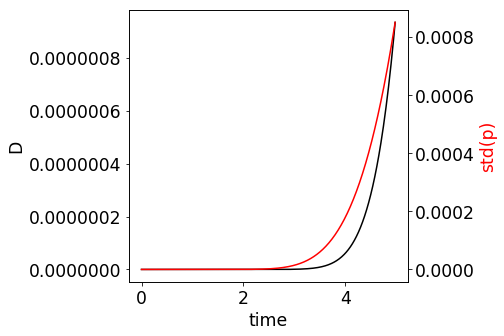

In [213]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
#plt.yscale('log')
#plt.ylim(1e-2,1)
#plt.xlim(0,3)
ax.set_xlabel('time',fontsize='xx-large')
ax.set_ylabel('D',fontsize='xx-large')
ax.plot(np.array(range(ntime - 1 ))*dt,gg.values(),'-',color='black')
ax.tick_params(labelsize='xx-large')

ax2=ax.twinx()
ax2.plot(np.array(range(ntime - 1 ))*dt,np.sqrt(var.values()),'-',color='red')
ax2.set_ylabel('std(p)',color='red',fontsize='xx-large')
ax2.tick_params(labelsize='xx-large')
plt.show()

### stress vs. time

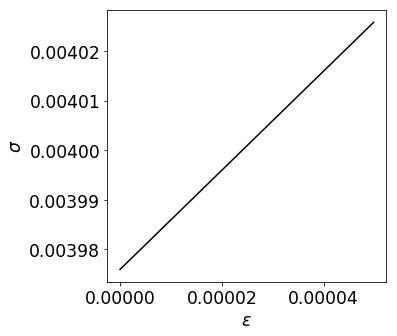

In [214]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
#plt.yscale('log')
#plt.ylim(1e-2,1)
#plt.xlim(0,100)
ax.set_xlabel('$\epsilon$',fontsize='xx-large')
ax.set_ylabel('$\sigma$',fontsize='xx-large')
ax.plot(np.array(range(ntime - 1 ))*dt*gammaDot,sigma_mean.values(),'-',color='black')
ax.tick_params(labelsize='xx-large')

# ax2=ax.twinx()
# ax2.plot(np.array(range(ntime - 1 ))*dt,np.sqrt(var.values()),'-',color='red')
# ax2.set_ylabel('std(p)',color='red',fontsize='xx-large')
# ax2.tick_params(labelsize='xx-large')
plt.show()

### distributions

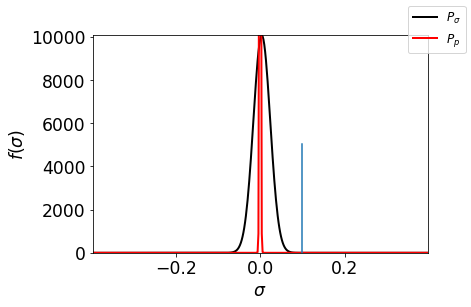

In [206]:
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-4*sigma_c,4*sigma_c)
ax.set_ylim(0,1*np.sum(f,axis=1).max())
ax.set_xlabel('$\sigma$',fontsize='xx-large')
ax.set_ylabel('$f(\sigma)$',fontsize='xx-large')
ax.tick_params(labelsize='xx-large')
#ax.set_yscale('log')
#ax.set_ylim(1e-8,1)

ax.plot(y, np.sum(f,axis=1), color='k', lw=2, label=r'$P_{\sigma}$')[0]
ax.plot(x, np.sum(f,axis=0), color='red', lw=2, label=r'$P_{p}$')[0]
ax.plot([sigma_c,sigma_c],[0,0.5*np.sum(f,axis=1).max()])
fig.legend(fontsize='large')



In [163]:
# from mpl_toolkits.mplot3d import Axes3D
# fig=plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111,projection='3d')
# # ax.set_xlim(-1.5*sigma_c,1.5*sigma_c)
# # ax.set_ylim(-1.5*sigma_c,1.5*sigma_c)
# # ax.set_zlim(0,2*np.sum(f,axis=1).max())
# ax.set_xlabel('$p$',fontsize='xx-large')
# ax.set_ylabel('$\sigma$',fontsize='xx-large')

# #ax.contour3D(xv,yv,f,50)
# xx=xv.flatten()
# yy=yv.flatten()
# zz=f.flatten()
# ax.scatter(xx[zz>0],yy[zz>0],zz[zz>0],s=0.1)

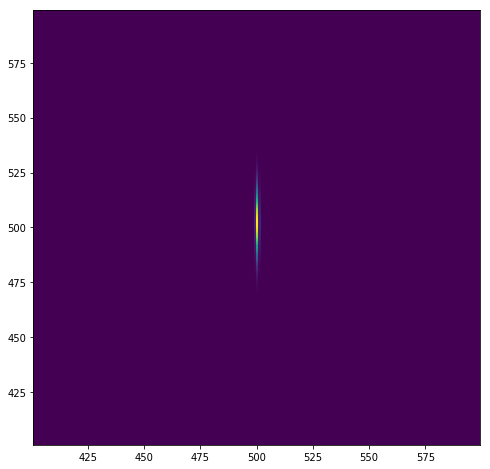

In [207]:
rr = 1000
xx = np.linspace(0,(ngrid)*dx,ngrid)

fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.pcolormesh(f)
ax.plot(xx,xx+sigma_c,c='white')
#ax.plot(xx,xx+sigma_c-xx+ngrid/2,c='white')

ax.set_xlim(ngrid/2-rr*sigma_c,ngrid/2+rr*sigma_c)
ax.set_ylim(ngrid/2-rr*sigma_c,ngrid/2+rr*sigma_c)
plt.show()

# Simulations
## Parameters

In [28]:
nfreq = 100000
timestep = 0.01
gammaDot = 0.00001

## Parse data
### Stress

In [35]:
import pandas as pd


#--- read stress
path = '/Users/Home/Desktop/Tmp/txt/dataVonMises/stress.xyz'
cols = open( path ).readlines()[8].split()#[2:] #--- column names
nrows = int(open(path).readlines()[3])
#
itime = 0
df_strs = {}
while itime < 200: #True:
    df_strs[ itime ] = pd.read_csv( path, sep="\t",
                        skiprows=9+(9+nrows)*itime,names=cols,index_col=False, nrows=nrows)
    df_strs[ itime ]['sigma'] =  0.5 * ( df_strs[ itime ]['sxx'] - df_strs[ itime ]['syy'] )
    df_strs[ itime ]['press'] = -0.5 * ( df_strs[ itime ]['sxx'] + df_strs[ itime ]['syy'] )
    
    if not len(df_strs) > 0:
        break
    itime += 1
    #print col
    



### Volume

In [21]:
#--- read volume
path = '/Users/Home/Desktop/Tmp/txt/dataVonMises/volume.xyz'
cols = open( path ).readlines()[8].split() #--- column names
nrows = int(open(path).readlines()[3])
df_vol = pd.read_csv( path, sep="\t",
                      skiprows=9,names=cols,index_col=False, nrows=nrows)
df_vol.head()

,Atoms,vol
0,0,0.836387
1,1,0.550083
2,2,0.547522
3,3,0.875179
4,4,0.838363


### Yield stress

In [69]:
path = '/Users/Home/Desktop/Tmp/txt/dataVonMises/moduli.txt'
cols = open( path ).readlines()[0].split(', ')#[2:] #--- column names
df_uniax = pd.read_csv( path, sep=" ", comment='#', names=cols)#,
#                      skiprows=9,names=cols,index_col=False, nrows=nrows)
df_uniax.head()

,#type,kbulk,gmod,uniax,epsrc,frict,hards,min uniax,min frict,reduc,redup,reduf,<uniax>,pcrit,min pcrit
0,0,2.0,1.0,0.019412,80.0,1.134464,-1.9,0.01,1.134464,0.0,0.0,0.0,0.1,2000000.0,0.0
1,1,2.0,1.0,0.096752,80.0,1.134464,-1.9,0.01,1.134464,0.0,0.0,0.0,0.1,2000000.0,0.0
2,2,2.0,1.0,0.080972,80.0,1.134464,-1.9,0.01,1.134464,0.0,0.0,0.0,0.1,2000000.0,0.0
3,3,2.0,1.0,0.045852,80.0,1.134464,-1.9,0.01,1.134464,0.0,0.0,0.0,0.1,2000000.0,0.0
4,4,2.0,1.0,0.099569,80.0,1.134464,-1.9,0.01,1.134464,0.0,0.0,0.0,0.1,2000000.0,0.0


In [189]:
12800**.5

113.13708498984761

#### PDF

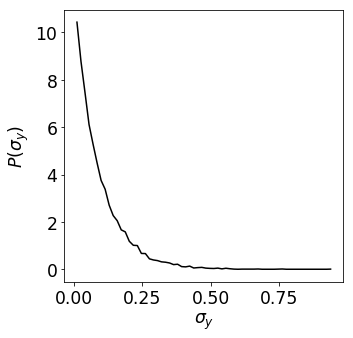

In [71]:
val = df_uniax['uniax']
hist, bin_edges = np.histogram(val, bins = 64, density = True )

#--- plot
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
#plt.yscale('log')
#plt.ylim(1e-2,1)
#plt.xlim(0,100)
ax.set_ylabel('$P(\sigma_y)$',fontsize='xx-large')
ax.set_xlabel('$\sigma_y$',fontsize='xx-large')
ax.plot( bin_edges[:-1], hist,'-',color='black')
ax.tick_params(labelsize='xx-large')

# ax2=ax.twinx()
# ax2.plot(np.array(range(ntime - 1 ))*dt,np.sqrt(var.values()),'-',color='red')
# ax2.set_ylabel('std(p)',color='red',fontsize='xx-large')
# ax2.tick_params(labelsize='xx-large')
plt.show()

In [60]:
help(open( path ).readlines()[0].split)

Help on built-in function split:

split(...)
    S.split([sep [,maxsplit]]) -> list of strings
    
    Return a list of the words in the string S, using sep as the
    delimiter string.  If maxsplit is given, at most maxsplit
    splits are done. If sep is not specified or is None, any
    whitespace string is a separator and empty strings are removed
    from the result.



## Stress vs. time

In [36]:
itime = 0
sbulk = {}
pbulk = {}
strain = {}
for itime in df_strs:
    sbulk[ itime ] = 0.5 * (( df_strs[ itime ]['sxx'] - df_strs[ itime ]['syy'] ) * df_vol['vol']).sum()/df_vol['vol'].sum()
    pbulk[ itime ] = -0.5 * (( df_strs[ itime ]['sxx'] + df_strs[ itime ]['syy'] ) * df_vol['vol']).sum()/df_vol['vol'].sum()
    strain[ itime ] = itime * timestep * gammaDot * nfreq

### plot

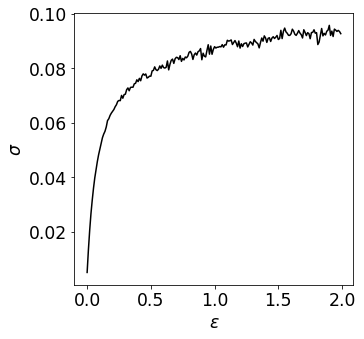

In [37]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
#plt.yscale('log')
#plt.ylim(1e-2,1)
#plt.xlim(0,100)
ax.set_xlabel('$\epsilon$',fontsize='xx-large')
ax.set_ylabel('$\sigma$',fontsize='xx-large')
ax.plot( strain.values(),sbulk.values(),'-',color='black')
ax.tick_params(labelsize='xx-large')

# ax2=ax.twinx()
# ax2.plot(np.array(range(ntime - 1 ))*dt,np.sqrt(var.values()),'-',color='red')
# ax2.set_ylabel('std(p)',color='red',fontsize='xx-large')
# ax2.tick_params(labelsize='xx-large')
plt.show()

## Distributions

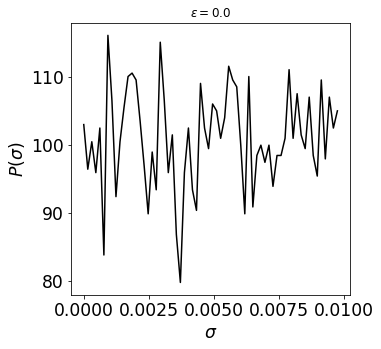

In [164]:
itime = 0
val = df_strs[itime]['sigma']
hist, bin_edges = np.histogram(val, bins = 64, density = True )

#--- plot
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
#plt.yscale('log')
#plt.ylim(1e-2,1)
#plt.xlim(0,100)
ax.set_ylabel('$P(\sigma)$',fontsize='xx-large')
ax.set_xlabel('$\sigma$',fontsize='xx-large')
ax.plot( bin_edges[:-1], hist,'-',color='black')
ax.tick_params(labelsize='xx-large')
ax.set_title( '$\epsilon=%s$'% ( itime * timestep * gammaDot * nfreq ) )

# ax2=ax.twinx()
# ax2.plot(np.array(range(ntime - 1 ))*dt,np.sqrt(var.values()),'-',color='red')
# ax2.set_ylabel('std(p)',color='red',fontsize='xx-large')
# ax2.tick_params(labelsize='xx-large')
plt.show()

0.9999999999999949


(480.176628470915, 519.823371529085)

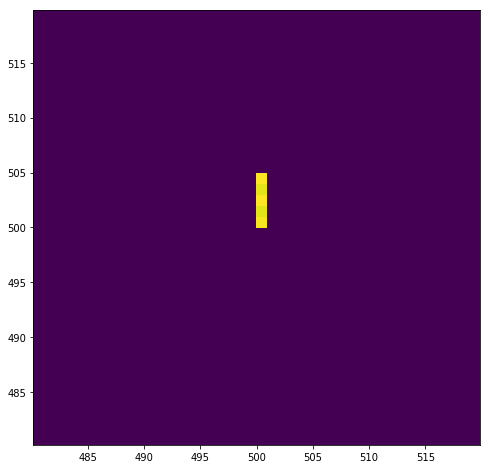

In [216]:
itime = 0
xedges = np.linspace(-(ngrid/2)*dx,(ngrid/2)*dx+dx,ngrid+1)
yedges = np.linspace(-(ngrid/2)*dy,(ngrid/2)*dy+dy,ngrid+1)
H, xedges, yedges = np.histogram2d(df_strs[itime]['press'],df_strs[itime]['sigma'],
                                   bins=(xedges,yedges),density=True)
f0 = H.T
print np.sum( f0 ) * dx * dy
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.pcolormesh(f0)

rr=200
ax.set_xlim(ngrid/2-rr*sigma_c,ngrid/2+rr*sigma_c)
ax.set_ylim(ngrid/2-rr*sigma_c,ngrid/2+rr*sigma_c)



In [171]:
f0.shape

(201, 201)

In [107]:
help(np.histogram2d)

Help on function histogram2d in module numpy:

histogram2d(x, y, bins=10, range=None, normed=None, weights=None, density=None)
    Compute the bi-dimensional histogram of two data samples.
    
    Parameters
    ----------
    x : array_like, shape (N,)
        An array containing the x coordinates of the points to be
        histogrammed.
    y : array_like, shape (N,)
        An array containing the y coordinates of the points to be
        histogrammed.
    bins : int or array_like or [int, int] or [array, array], optional
        The bin specification:
    
          * If int, the number of bins for the two dimensions (nx=ny=bins).
          * If array_like, the bin edges for the two dimensions
            (x_edges=y_edges=bins).
          * If [int, int], the number of bins in each dimension
            (nx, ny = bins).
          * If [array, array], the bin edges in each dimension
            (x_edges, y_edges = bins).
          * A combination [int, array] or [array, int], wher

In [92]:
ngrid

101